Comencemos por importar las librerías que necesitaremos a lo largo de la tarea

In [20]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

np.random.seed(33)

Implementemos una función para cargar los datos, normalizarlos, aplanarlos. En esta ocasión no agregaremos una entrada afín ya que el modelo lo hace de por si. Haremos una función para cada uno de los conjuntos de datos que utilizaremos

In [21]:
def cargar_datos_mnist():

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    x_train = x_train.reshape(-1, 28 * 28)
    x_test = x_test.reshape(-1, 28 * 28)

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 50000, random_state = 33)

    return x_train, y_train, x_test, y_test, x_val, y_val

In [22]:
def cargar_datos_cifar10():

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    x_train = x_train.reshape(-1, 32*32*3)
    x_test = x_test.reshape(-1, 32*32*3)

    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 42000, random_state = 33)

    return x_train, y_train, x_test, y_test, x_val, y_val

También implementemos una función que nos permita acceder a una muestra de un conjunto de datos, esto será muy útil puesto que nos servirá para poder implementar correctamente la obtención de un batch de datos.

In [23]:
def random_subset(tamano, X, Y):
    n, d = X.shape
    indices = np.random.choice(n, size=tamano, replace=False)
    newX = X[indices]
    newY = Y[indices]
    return newX, newY

Ahora implementemos la red neuronal. Nos basamos en el apunte proporcionado por el profesor en el enunciado. Hice un par de cambios para mejorar la estabilidad del logaritmo y la exponencial. Además, decidí no regularizar los vectores de sesgo, ya que solo nos mueven afínmente. Creo que la implementación me quedó clara así que se puede revisar en más profundidad a continuación.

In [28]:
def NeuralNetwork(X, Y, eta, m, p, Lambda):

    tiempo_inicial = time.time()
    iters = 0
    d = X.shape[1]
    K = len(np.unique(Y))
    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    b1 = np.zeros(p)
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    b2 = np.zeros(K)
    W1grad = np.zeros((d, p))
    b1grad = np.zeros(p)
    W2grad = np.zeros((p, K))
    b2grad = np.zeros(K)

    while time.time() - tiempo_inicial < 60.0:

        Xbatch, Ybatch = random_subset(m, X, Y)

        z1 = Xbatch.dot(W1) + b1
        a1 = np.maximum(z1, 0)
        z2 = a1.dot(W2) + b2
        z2 -= np.max(z2, axis=1, keepdims=True)
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch] + 1e-10)
        data_loss = np.sum(corect_logprobs)/m
        reg_loss = 0.5 * Lambda *(np.sum(W1 * W1) + np.sum(W2 * W2))
        loss = data_loss + reg_loss

        dscores = a2
        dscores[range(m), Ybatch] -= 1
        dscores /= m
        W2grad = np.dot(a1.T, dscores)
        b2grad = np.sum(dscores, axis=0)
        dhidden = np.dot(dscores, W2.T)
        dhidden[a1 <= 0] = 0
        W1grad = np.dot(Xbatch.T, dhidden)
        b1grad = np.sum(dhidden, axis=0)
        W2grad += Lambda * W2
        W1grad += Lambda * W1

        W1 += -eta*W1grad
        b1 += -eta*b1grad
        W2 += -eta*W2grad
        b2 += -eta*b2grad
        iters += 1

        if np.linalg.norm(W1grad) + np.linalg.norm(W2grad) < 1e-5:
            break

    return W1, b1, W2, b2, time.time() - tiempo_inicial, iters


Además, implementé una función análoga a la red neuronal para obtener estadísticas más detalladas durante la ejecución. En particular, obtengo por cada porcentaje de avance del modelo una muestra de la curva de riesgo, y lo hago para cada uno de los conjuntos de datos.

In [30]:
def NeuralNetworkStats(x_train, y_train, x_test, y_test, x_val, y_val, iters, eta, m, p, Lambda):

    d = x_train.shape[1]
    K = len(np.unique(y_train))
    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    b1 = np.zeros(p)
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    b2 = np.zeros(K)
    W1grad = np.zeros((d, p))
    b1grad = np.zeros(p)
    W2grad = np.zeros((p, K))
    b2grad = np.zeros(K)

    iters = iters + (100 - iters%100)%100
    trainstats = [0 for _ in range(101)]
    teststats = [0 for _ in range(101)]
    valstats = [0 for _ in range(101)]

    for i in range(iters+1):

        Xbatch, Ybatch = random_subset(m, x_train, y_train)

        z1 = Xbatch.dot(W1) + b1
        a1 = np.maximum(z1, 0)
        z2 = a1.dot(W2) + b2
        z2 -= np.max(z2, axis=1, keepdims=True)
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch] + 1e-10)
        data_loss = np.sum(corect_logprobs)/m
        reg_loss = 0.5 * Lambda *(np.sum(W1 * W1) + np.sum(W2 * W2))
        loss = data_loss + reg_loss

        dscores = a2
        dscores[range(m), Ybatch] -= 1
        dscores /= m
        W2grad = np.dot(a1.T, dscores)
        b2grad = np.sum(dscores, axis=0)
        dhidden = np.dot(dscores, W2.T)
        dhidden[a1 <= 0] = 0
        W1grad = np.dot(Xbatch.T, dhidden)
        b1grad = np.sum(dhidden, axis=0)
        W2grad += Lambda * W2
        W1grad += Lambda * W1

        W1 += -eta*W1grad
        b1 += -eta*b1grad
        W2 += -eta*W2grad
        b2 += -eta*b2grad

        if i%(iters//100) == 0:
            trainstats[i//(iters//100)] = validar(W1, b1, W2, b2, x_train, y_train)
            teststats[i//(iters//100)] = validar(W1, b1, W2, b2, x_test, y_test)
            valstats[i//(iters//100)] = validar(W1, b1, W2, b2, x_val, y_val)

    return trainstats, teststats, valstats

Además, vamos a tener una función que nos permita obtener el porcentaje de error del modelo. Esto nos será muy útil para poder determinar que modelo funciona mejor, y obtener estadísticas detalladas de su rendimiento

In [31]:
def validar(W1, b1, W2, b2, X, Y):
    z1 = X.dot(W1) + b1
    a1 = np.maximum(z1, 0)
    z2 = a1.dot(W2) + b2
    a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)
    Ypred = np.argmax(a2, axis=1)
    error = np.mean(Ypred != Y)
    return error

Comencemos con el experimento para la base de datos MNIST. Primero carguemos los datos

In [32]:
x_train, y_train, x_test, y_test, x_val, y_val = cargar_datos_mnist()

Ahora hagamos una búsqueda sobre los dos parámetros que se nos pide en el enunciado (ancho de capa y constante de regularización). Para los otros dos parámetros consideraremos la constante de learning rate de 0.1 y tamaño de batch de 10 ya que fueron los que mejores resultados nos dieron en la tarea 2. Recordemos que el mejor porcentaje de error que obtuvimos en la tarea 2 fue de un 6.5%

In [35]:
validation_errors = [[0 for _ in range(3)] for _ in range(3)]
i = 0
j = 0

for p in [100, 1000, 10000]:
    for Lambda in [0, 0.01, 0.1]:
        W1, b1, W2, b2, tiempo, iters = NeuralNetwork(x_train, y_train, 0.1, 10, p, Lambda)
        error = validar(W1, b1, W2, b2, x_val, y_val)
        validation_errors[i][j] = error
        j += 1
        print(f"El modelo con tamaño de capa interior de {p} y regularizador {Lambda} se tardó {tiempo:.2f}s en {iters} iteraciones y tuvo error de validación de {error:.3f}")
    i += 1
    j = 0

El modelo con tamaño de capa interior de 100 y regularizador 0 se tardó 60.00s en 15470 iteraciones y tuvo error de validación de 0.035
El modelo con tamaño de capa interior de 100 y regularizador 0.01 se tardó 60.00s en 17219 iteraciones y tuvo error de validación de 0.083
El modelo con tamaño de capa interior de 100 y regularizador 0.1 se tardó 60.00s en 17526 iteraciones y tuvo error de validación de 0.256
El modelo con tamaño de capa interior de 1000 y regularizador 0 se tardó 60.02s en 3305 iteraciones y tuvo error de validación de 0.041
El modelo con tamaño de capa interior de 1000 y regularizador 0.01 se tardó 60.01s en 3566 iteraciones y tuvo error de validación de 0.086
El modelo con tamaño de capa interior de 1000 y regularizador 0.1 se tardó 60.01s en 3153 iteraciones y tuvo error de validación de 0.227
El modelo con tamaño de capa interior de 10000 y regularizador 0 se tardó 60.02s en 291 iteraciones y tuvo error de validación de 0.105
El modelo con tamaño de capa interior 

Ya se ha realizado el experimento. Lo primero que podemos notar es que ningún modelo alcanzó a converger (en parte porque pusimos una condición de término bastante estricta). Grafiquemos estos resultados

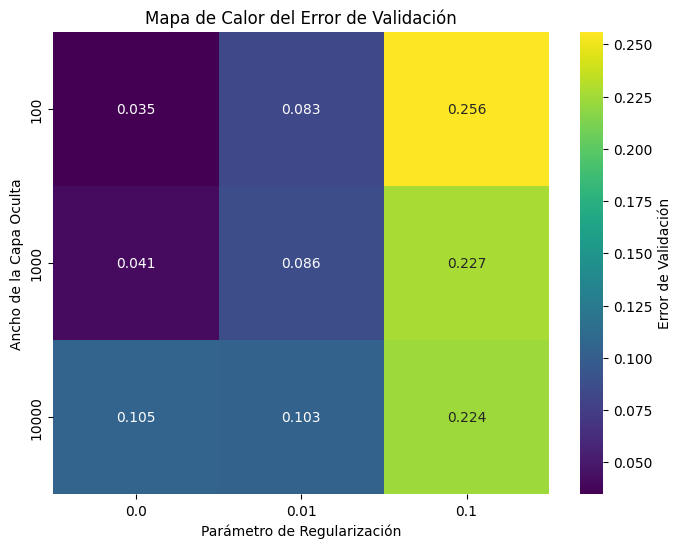

In [36]:
df = pd.DataFrame(validation_errors, index=[100, 1000, 10000], columns=[0, 0.01, 0.1])
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="viridis", fmt=".3f", cbar_kws={'label': 'Error de Validación'})
plt.xlabel("Parámetro de Regularización")
plt.ylabel("Ancho de la Capa Oculta")
plt.title("Mapa de Calor del Error de Validación")
plt.show()

Podemos notar que solo hubieron dos modelos que vencieron al de la tarea 2. En este sentido podemos concluir que lo más beneficioso era que el parámetro de regularización fuera nulo y que el ancho de la capa oculta fuera pequeño. Nos quedamos con el primer modelo y veamos la evolución de la curva de riesgo a lo largo del entrenamiento. Primero obtengamos los datos

In [37]:
trainstats, teststats, valstats = NeuralNetworkStats(x_train, y_train, x_test, y_test, x_val, y_val, 15470, 0.1, 10, 100, 0.0)

Ahora graficamos

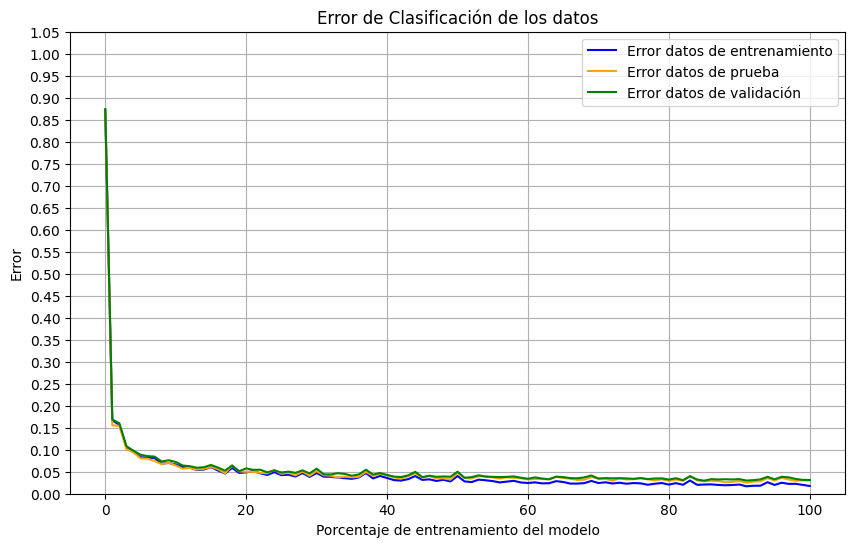

In [38]:
porcentajes = np.linspace(0, 100, 101)

plt.figure(figsize=(10, 6))

plt.plot(porcentajes, trainstats, label = 'Error datos de entrenamiento', color = 'blue')
plt.plot(porcentajes, teststats, label = 'Error datos de prueba', color = 'orange')
plt.plot(porcentajes, valstats, label = 'Error datos de validación', color = 'green')

plt.title('Error de Clasificación de los datos')
plt.xlabel('Porcentaje de entrenamiento del modelo')
plt.ylabel('Error')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.legend()
plt.grid()
plt.show()

Podemos notar que la evolución al inicio es muy brusca, y posteriormente se hace más ligera. Otra cosa importante a notar es que las curvas son bastantes cercanas por lo que no se está sobreajustando (al menos no demasiado, ya que la curva azul está levemente por debajo).

Ahora hagamos el experimento con el conjunto de datos CIFAR10. Comencemos por cargar dichos datos

In [39]:
x_train, y_train, x_test, y_test, x_val, y_val = cargar_datos_cifar10()

Y repitamos el experimento con esta nueva base de datos

In [40]:
validation_errors = [[0 for _ in range(3)] for _ in range(3)]
i = 0
j = 0

for p in [100, 1000, 10000]:
    for Lambda in [0, 0.01, 0.1]:
        W1, b1, W2, b2, tiempo, iters = NeuralNetwork(x_train, y_train, 0.1, 10, p, Lambda)
        error = validar(W1, b1, W2, b2, x_val, y_val)
        validation_errors[i][j] = error
        j += 1
        print(f"El modelo con tamaño de capa interior de {p} y regularizador {Lambda} se tardó {tiempo:.2f}s en {iters} iteraciones y tuvo error de validación de {error:.3f}")
    i += 1
    j = 0

El modelo con tamaño de capa interior de 100 y regularizador 0 se tardó 0.15s en 27 iteraciones y tuvo error de validación de 0.900
El modelo con tamaño de capa interior de 100 y regularizador 0.01 se tardó 60.00s en 8813 iteraciones y tuvo error de validación de 0.848
El modelo con tamaño de capa interior de 100 y regularizador 0.1 se tardó 60.01s en 9052 iteraciones y tuvo error de validación de 0.845
El modelo con tamaño de capa interior de 1000 y regularizador 0 se tardó 60.01s en 673 iteraciones y tuvo error de validación de 0.799
El modelo con tamaño de capa interior de 1000 y regularizador 0.01 se tardó 60.05s en 680 iteraciones y tuvo error de validación de 0.856
El modelo con tamaño de capa interior de 1000 y regularizador 0.1 se tardó 60.02s en 652 iteraciones y tuvo error de validación de 0.856
El modelo con tamaño de capa interior de 10000 y regularizador 0 se tardó 60.19s en 58 iteraciones y tuvo error de validación de 0.815
El modelo con tamaño de capa interior de 10000 y

Se puede ver que el único modelo que alcanzó a converger fue el primero, pero tuvo un rendimiento pésimo (similar a simplemnte escoger la clasificación al azar). Veamos con más detalle los resultados en un mapa de calor

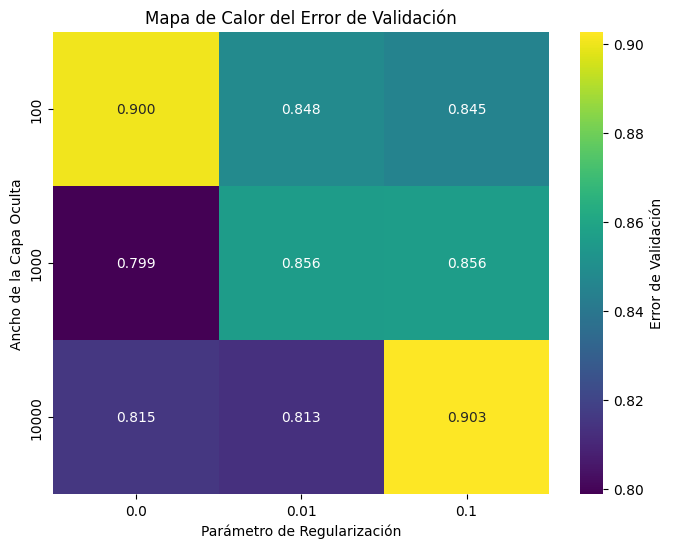

In [41]:
df = pd.DataFrame(validation_errors, index=[100, 1000, 10000], columns=[0, 0.01, 0.1])
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="viridis", fmt=".3f", cbar_kws={'label': 'Error de Validación'})
plt.xlabel("Parámetro de Regularización")
plt.ylabel("Ancho de la Capa Oculta")
plt.title("Mapa de Calor del Error de Validación")
plt.show()

Podemos ver que el rendimiento fue pésimo. Yo creo que esto se debe ya que la base de datos de CIFAR 10 es mucho más compleja, de hecho, típicamente se hace con redes neuronales multicapas o con redes convolucionales, lo que es claramente más poderoso que nuestro simple modelo. Además, el tiempo de ejecución mencionado en la tarea no es demasiado, por lo cual es dificil conseguir buenos resultados para una base de datos tan complejos. Aún así, veamos que ocurre con la curva de riesgo, primero obtengamos los datos

In [42]:
trainstats, teststats, valstats = NeuralNetworkStats(x_train, y_train, x_test, y_test, x_val, y_val, 673, 0.1, 10, 1000, 0.0)

Ahora grafiquemos

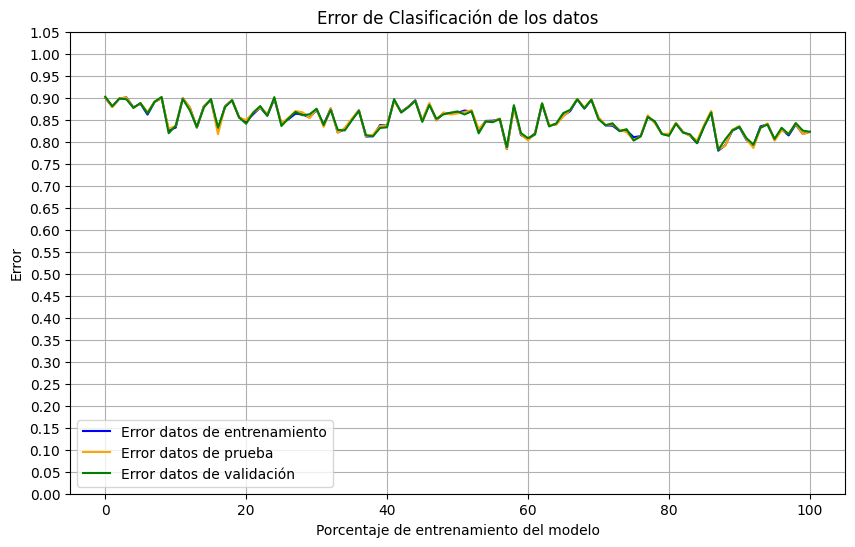

In [43]:
porcentajes = np.linspace(0, 100, 101)

plt.figure(figsize=(10, 6))

plt.plot(porcentajes, trainstats, label = 'Error datos de entrenamiento', color = 'blue')
plt.plot(porcentajes, teststats, label = 'Error datos de prueba', color = 'orange')
plt.plot(porcentajes, valstats, label = 'Error datos de validación', color = 'green')

plt.title('Error de Clasificación de los datos')
plt.xlabel('Porcentaje de entrenamiento del modelo')
plt.ylabel('Error')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.legend()
plt.grid()
plt.show()

Podemos concluír que aunque los resultados fueron lamentables, al menos no se sobreajusta :D